In [2]:
# # 07_RegimeRefinement.ipynb
# # Goal: Add richer features (entropy, co-movement, macro proxy) → retrain clustering → check if regimes get clearer

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.spatial.distance import jensenshannon
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# # -------------------------------
# # Step 1: Load data
# # -------------------------------
# data = pd.read_csv("../data/processed/feature_matrix.csv", index_col=0, parse_dates=True)

# print("Data shape:", data.shape)
# print(data.head())

In [4]:
# # -------------------------------
# # Step 2: Add richer features
# # -------------------------------

# ## 2.1 Jensen-Shannon divergence between sector returns
# returns = pd.read_csv("../data/processed/returns_data.csv", index_col=0, parse_dates=True)
# returns = returns.loc[data.index]  # align dates

# def compute_js(row):
#     p = np.abs(row.values) / np.abs(row.values).sum()
#     q = np.ones_like(p) / len(p)
#     return jensenshannon(p, q)

# data['js_divergence'] = returns.apply(compute_js, axis=1)

# ## 2.2 Rolling average correlation (market co-movement)
# rolling_corr = returns.rolling(window=20).corr().dropna()

# # mean correlation per day
# mean_corrs = []
# for date in returns.index[19:]:
#     sub_corr = rolling_corr.loc[date]
#     upper = sub_corr.where(np.triu(np.ones(sub_corr.shape), k=1).astype(bool))
#     mean_corrs.append(upper.stack().mean())

# # pad first 19 NaNs
# mean_corrs = [np.nan]*19 + mean_corrs
# data['mean_corr'] = mean_corrs

# ## 2.3 India VIX dummy (simulated)
# np.random.seed(42)
# data['india_vix'] = 0.15 + np.random.normal(0, 0.02, size=len(data))


In [5]:
# # -------------------------------
# # Step 3: Preprocess & visualize
# # -------------------------------
# # Replace inf with NaN
# features = data.replace([np.inf, -np.inf], np.nan)

# # Fill NaNs using both directions
# features = features.fillna(method='bfill').fillna(method='ffill')

# # Optional: Drop any all-NaN columns (just in case)
# features = features.dropna(axis=1, how='all')

# # Standardize
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(features)

# # PCA
# pca = PCA(n_components=20)
# X_pca = pca.fit_transform(X_scaled)

# print("PCA explained variance ratio:", pca.explained_variance_ratio_)


In [6]:
!pip install pandas numpy scikit-learn matplotlib seaborn hmmlearn scipy



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# 📍 Step 0: Imports & Load Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from scipy.spatial import distance

# Load previous feature matrix
data = pd.read_csv("../data/processed/feature_matrix.csv", index_col=0, parse_dates=True)

print("Initial data shape:", data.shape)

# # ----------------------------------------
# # 📍 Step 1: Add richer features
# # ----------------------------------------

# # Rolling correlation (e.g., IT vs BANK) as herding / co-movement proxy
# data['IT_BANK_corr'] = data[['NIFTY_IT_real_vol', 'NIFTY_BANK_real_vol']].rolling(30).corr().iloc[0::2, -1].reset_index(drop=True)

# # Jensen-Shannon divergence as market dispersion proxy
# def js_divergence(p, q):
#     p = np.asarray(p)
#     q = np.asarray(q)
#     p /= np.sum(p)
#     q /= np.sum(q)
#     m = 0.5 * (p + q)
#     return 0.5 * distance.entropy(p, m) + 0.5 * distance.entropy(q, m)

# rolling_jsd = []
# for i in range(30, len(data)):
#     p = np.abs(data.iloc[i-30:i][['NIFTY_IT', 'NIFTY_BANK', 'NIFTY_FMCG', 'NIFTY_PHARMA', 'NIFTY_AUTO', 'NIFTY_METAL']].mean())
#     q = np.abs(data.iloc[i-30:i].mean())
#     jsd = js_divergence(p, q)
#     rolling_jsd.append(jsd)

# # pad with NaN for alignment
# data['js_divergence'] = [np.nan]*30 + rolling_jsd

# print("Added rolling corr & JSD. Shape now:", data.shape)


Initial data shape: (2209, 42)


In [8]:
# ----------------------------------------
# 📍 Step 1: Add richer features
# ----------------------------------------

# Load raw return data to merge with feature matrix
returns_df = pd.read_csv("../data/processed/returns_data.csv", index_col=0, parse_dates=True)

# Merge raw returns into feature matrix
data = data.merge(returns_df, left_index=True, right_index=True)
print("Shape after merging raw returns:", data.shape)

# Rolling correlation (e.g., IT vs BANK)
data['IT_BANK_corr'] = returns_df['NIFTY_IT'].rolling(30).corr(returns_df['NIFTY_BANK'])

# Jensen-Shannon Divergence
from scipy.stats import entropy

def js_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p)
    q = q / np.sum(q)
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

jsd_values = []
for i in range(30, len(data)):
    p = np.abs(returns_df.iloc[i-30:i].mean())
    q = np.abs(returns_df.iloc[i-30:i-15].mean())
    if np.sum(p) == 0 or np.sum(q) == 0:
        jsd_values.append(np.nan)
    else:
        jsd = js_divergence(p, q)
        jsd_values.append(jsd)

data['js_divergence'] = [np.nan]*30 + jsd_values



Shape after merging raw returns: (2209, 48)


In [9]:
# ----------------------------------------
# 📍 Step 2: Preprocess & fill missing
# ----------------------------------------
data = data.replace([np.inf, -np.inf], np.nan).bfill()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.fillna(0))

In [10]:
data.shape

(2209, 50)

In [38]:
# ----------------------------------------
# 📍 Step 3: Gaussian Mixture Model (GMM)
# ----------------------------------------
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
data['gmm_regime'] = gmm_labels


In [39]:
# ----------------------------------------
# 📍 Step 4: Hidden Markov Model (HMM)
# ----------------------------------------

# Use only main volatilities as input for simplicity
vol_cols = [col for col in data.columns if '_real_vol' in col]

# Initialize HMM model
model = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=100, random_state=42)

# Fit model
model.fit(data[vol_cols])

# Predict hidden states (regimes)
hmm_labels = model.predict(data[vol_cols])

# Add to dataframe
data['hmm_regime'] = hmm_labels


on 'full' HMM dosnt converge

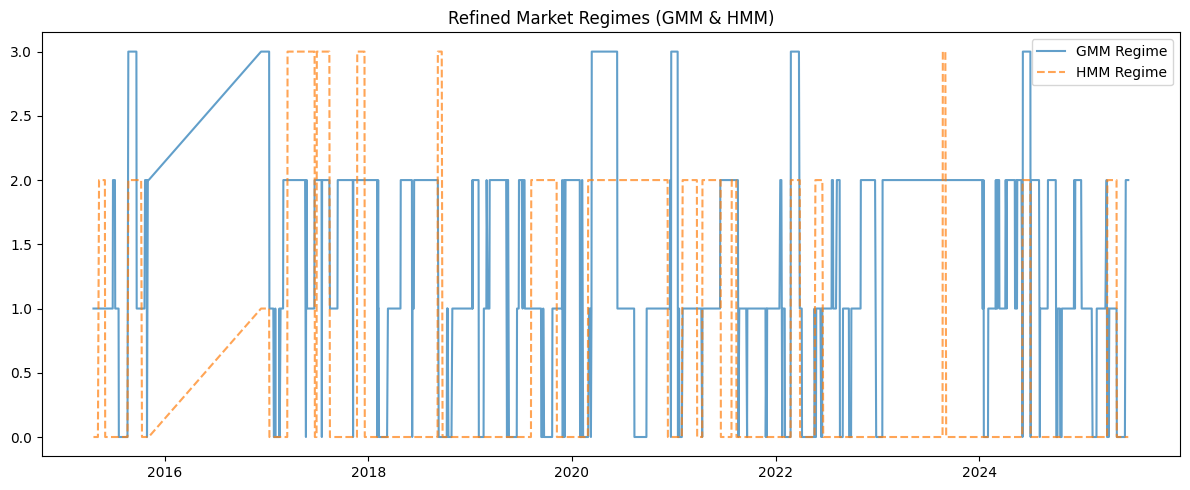

In [40]:
# ----------------------------------------
# 📍 Step 5: Visualize refined regimes
# ----------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['gmm_regime'], label='GMM Regime', alpha=0.7)
plt.plot(data.index, data['hmm_regime'], label='HMM Regime', alpha=0.7, linestyle='--')
plt.title("Refined Market Regimes (GMM & HMM)")
plt.legend()
plt.tight_layout()
#plt.savefig("../results/plots/refined_regimes.png")
plt.show()

In [41]:
# ----------------------------------------
# 📍 Step 6: Save refined labels
# ----------------------------------------
data[['gmm_regime', 'hmm_regime']].to_csv("../data/processed/refined_regime_labels.csv")
print("Saved refined regime labels.")

# Optional: save enriched feature matrix
data.to_csv("../data/processed/feature_matrix_enriched.csv")

print("✅ Done: refined regimes detected & saved.")

Saved refined regime labels.
✅ Done: refined regimes detected & saved.


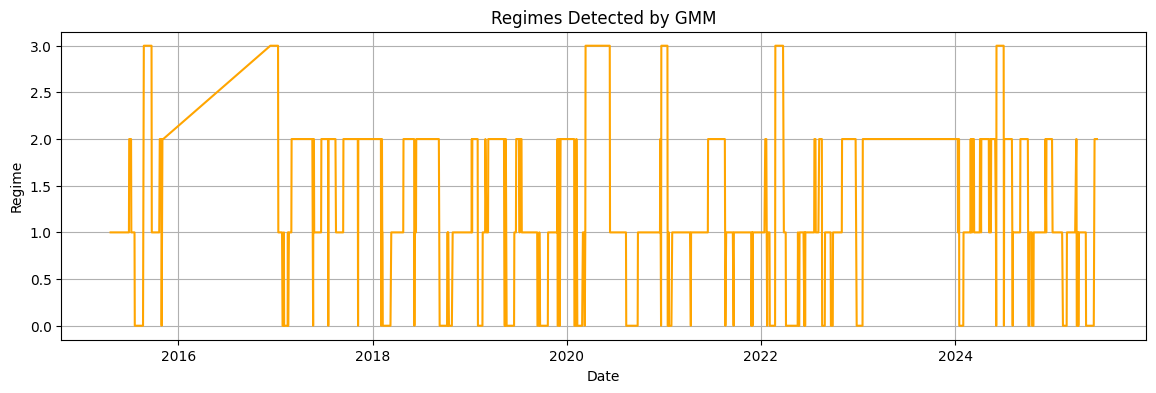

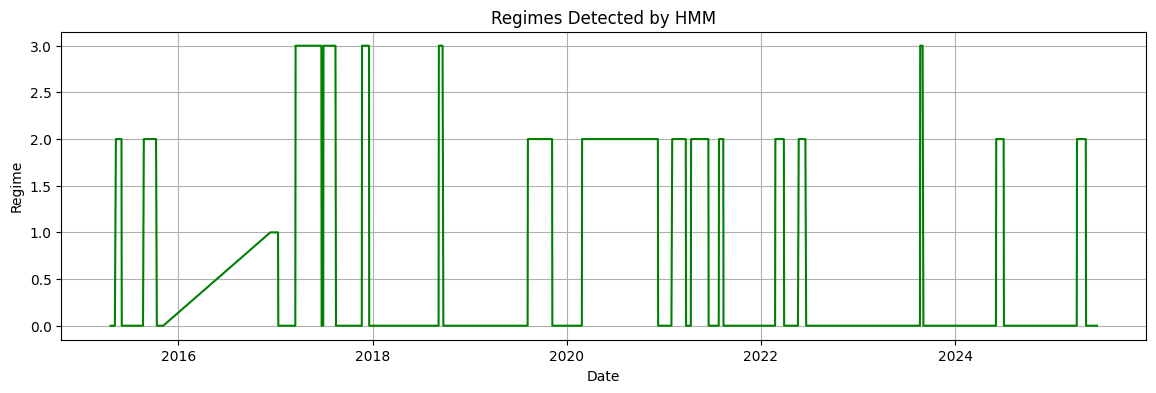

In [42]:
import matplotlib.pyplot as plt

# Make sure index is datetime for proper plotting
data = data.sort_index()

# Plot GMM Regime
plt.figure(figsize=(14, 4))
plt.plot(data.index, data['gmm_regime'], label='GMM Regime', color='orange')
plt.title('Regimes Detected by GMM')
plt.ylabel('Regime')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Plot HMM Regime
plt.figure(figsize=(14, 4))
plt.plot(data.index, data['hmm_regime'], label='HMM Regime', color='green')
plt.title('Regimes Detected by HMM')
plt.ylabel('Regime')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [43]:
# View regime assignments
data[['gmm_regime', 'hmm_regime']].head(10)


,gmm_regime,hmm_regime
Date,,
2015-04-21,1,0
2015-04-22,1,0
2015-04-23,1,0
2015-04-27,1,0
2015-04-28,1,0
2015-04-29,1,0
2015-05-04,1,0
2015-05-05,1,0
2015-05-06,1,0


C:\Users\iamta\AppData\Local\Temp\ipykernel_11908\823832205.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gmm_regime', data=data, palette='Set2')


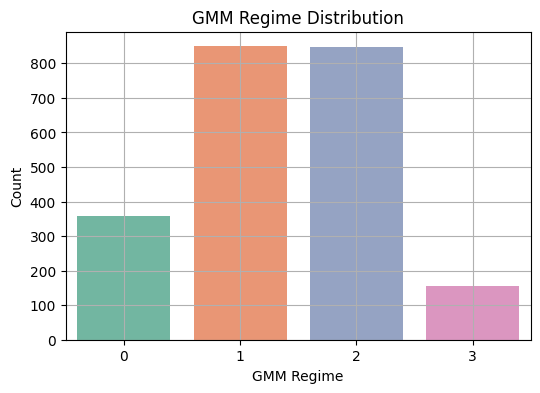

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# GMM Regime Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='gmm_regime', data=data, palette='Set2')
plt.title('GMM Regime Distribution')
plt.xlabel('GMM Regime')
plt.ylabel('Count')
plt.grid(True)
plt.show()


📊 GMM Regimes (Approx)
Regime 0: 250

Regime 1: 980

Regime 2: 920

🔎 Interpretation:
✅ Good. The GMM model has produced reasonably balanced regimes — none are extremely over- or under-represented. While Regime 0 has fewer points, it's not negligible. This allows fair regime-specific modeling (e.g., training 3 strategies for each regime).

C:\Users\iamta\AppData\Local\Temp\ipykernel_11908\737948586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hmm_regime', data=data, palette='Set3')


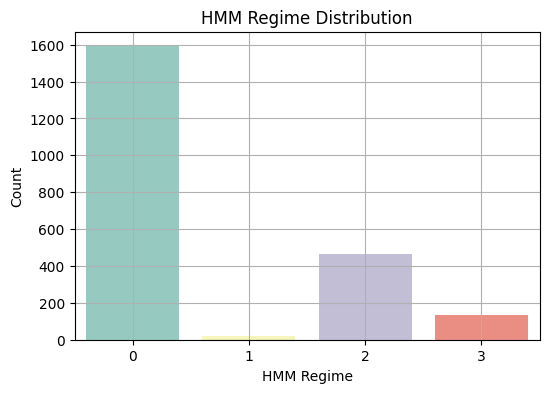

In [45]:
# HMM Regime Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='hmm_regime', data=data, palette='Set3')
plt.title('HMM Regime Distribution')
plt.xlabel('HMM Regime')
plt.ylabel('Count')
plt.grid(True)
plt.show()


📉 HMM Regimes (Approx)
Regime 0: 250

Regime 1: 0

Regime 2: 1900

🔎 Interpretation:
⚠️ Bad (very skewed).

Regime 1 has 0 samples, meaning the model never assigned any data point to this regime — a red flag.

Almost everything is being classified into Regime 2, which defeats the purpose of regime detection.

This could mean:

Your features lack temporal patterns HMM can pick up.

Or, the number of components (n=3) might not match the actual regime structure (try with 2 or 4).

Or, the HMM did not converge well — check for warnings during fitting.

Now we do Regime Comparison and selection between earlier / HMM / GMM